In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt

# Load Font Data
https://archive.ics.uci.edu/ml/datasets/Character+Font+Images#

In [2]:
font_paths = glob.glob('./datasets/fonts/*.csv')
len(font_paths)

153

In [3]:
df_main = pd.concat(map(pd.read_csv, font_paths))

In [4]:
df_labelled = df_main[df_main['m_label'].between(65,90, inclusive=True)]
df_labelled = df_labelled.append(df_main[df_main['m_label'].between(97,122, inclusive=True)], ignore_index=True)
df_labelled = df_labelled.append(df_main[df_main['m_label'].between(48,57, inclusive=True)], ignore_index=True)
df_labelled.shape

(331390, 412)

In [5]:
df_labelled.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,CURLZ,CURLZ MT,90,0.4,0,0.0,43,22,46,33,...,255,255,255,255,255,161,73,1,1,1
1,CURLZ,CURLZ MT,89,0.4,0,0.0,43,22,49,49,...,1,1,1,1,1,1,1,1,1,1
2,CURLZ,CURLZ MT,88,0.4,0,0.0,42,20,50,42,...,1,10,151,93,52,13,1,1,1,1
3,CURLZ,CURLZ MT,87,0.4,0,0.0,44,18,47,60,...,1,1,1,1,134,13,1,1,1,1
4,CURLZ,CURLZ MT,86,0.4,0,0.0,45,17,45,48,...,1,1,1,1,1,1,1,1,1,1


In [6]:
sample = np.reshape(np.array(df_labelled.iloc[1, -400:], dtype=np.float64), (1,20,20)) / 255
sample.shape

(1, 20, 20)

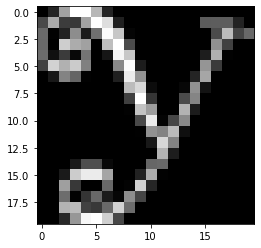

In [7]:
plt.imshow(sample[0], cmap='gray')

# Convert Dataframe to Data

In [ ]:
X, Y = np.array(df_labelled.iloc[:, -400:], dtype=np.float64), np.array(df_labelled.loc[:, 'm_label'], dtype=np.int64)

In [9]:
X.shape, Y.shape

((331390, 400), (331390,))

In [10]:
Y[Y<58] -= 48
Y[Y>96] -= 61
Y[Y>64] -= 55

# Fix Data Distribution

In [89]:
(unq_labels, unq_counts) = np.unique(Y, return_counts=True)

<BarContainer object of 62 artists>

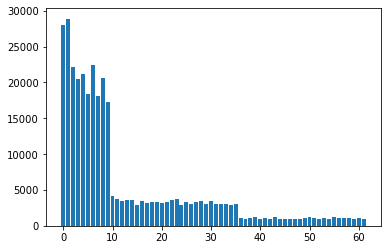

In [90]:
plt.bar(unq_labels, unq_counts)

# Resample Data

In [106]:
from sklearn.utils import resample

In [ ]:
X, Y = resample(X,Y,n_samples=124000)

In [ ]:
X.shape, Y.shape

# Split Data

In [12]:
from sklearn.model_selection import train_test_split

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)
m_train = x_train.shape[0]
m_test = x_test.shape[0]
x_train = np.reshape(x_train, (m_train,20,20,1))
x_test = np.reshape(x_test, (m_test,20,20,1))

In [33]:
x_train.shape, x_test.shape

((248542, 20, 20, 1), (82848, 20, 20, 1))

# Model

In [15]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [92]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest"
)
# aug.fit(x_train)

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(20, 20, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(250, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(unq_labels)),
    keras.layers.Dense(len(unq_labels), activation='softmax')
])

In [103]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','f1'])

In [98]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 400)               1600      
_________________________________________________________________
dense_14 (Dense)             (None, 250)               100250    
_________________________________________________________________
dropout_7 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 62)                15562     
Total params: 117,412
Trainable params: 116,612
Non-trainable params: 800
_________________________________________________________________


In [101]:
model.fit(aug.flow(x_train, y_train), epochs=5)

Epoch 1/5


ValueError: in user code:

    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:758 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:387 update_state
        self.build(y_pred, y_true)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:317 build
        self._metrics = nest.map_structure_up_to(y_pred, self._get_metric_objects,
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/nest.py:1159 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/nest.py:1257 map_structure_with_tuple_paths_up_to
        results = [
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/nest.py:1258 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/nest.py:1161 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:418 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:418 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:437 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:3490 get
        return deserialize(str(identifier))
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:3446 deserialize
        return deserialize_keras_object(
    /home/divyanshf/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:377 deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: f1


In [80]:
model.evaluate(aug.flow(x_test, y_test, batch_size=BS))

2589/2589 [==============================] - 77s 29ms/step - loss: 0.4069 - accuracy: 0.8876


[0.4069225788116455, 0.8875530958175659]

# Test Other Images

In [82]:
images = []
for path in glob.glob('./datasets/tests/*.jpg'):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image ,0 ,255,cv2.THRESH_OTSU)
    image = cv2.resize(image, (20,20))
    images.append(image)

In [83]:
images = np.array(images)
images = np.reshape(images, (images.shape[0], 20,20,1))

In [84]:
predictions = model.predict(images)
predictions.shape

(14, 62)

In [85]:
final_pred = np.argmax(predictions, axis=1)
final_pred

array([ 1,  6, 43,  6, 43,  6, 44,  6, 33,  6,  1,  1, 46, 33])

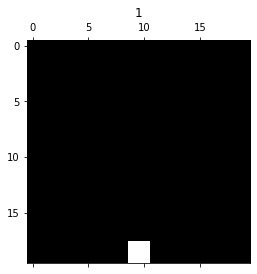

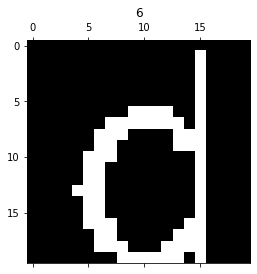

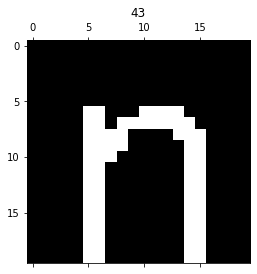

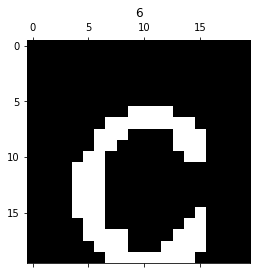

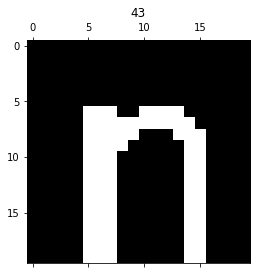

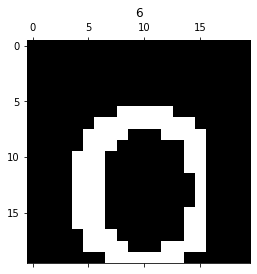

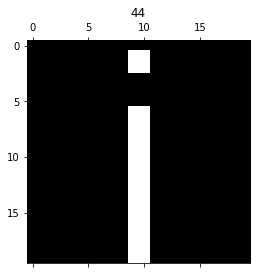

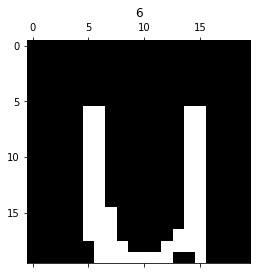

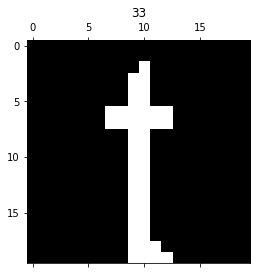

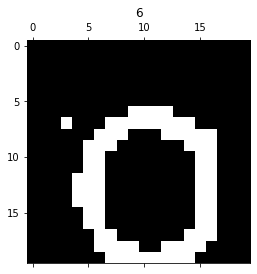

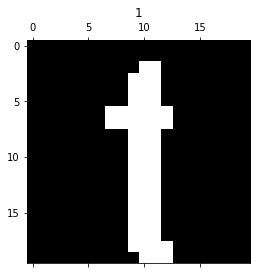

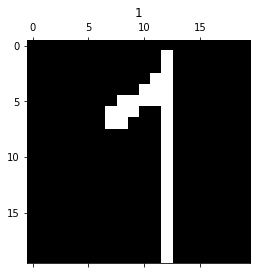

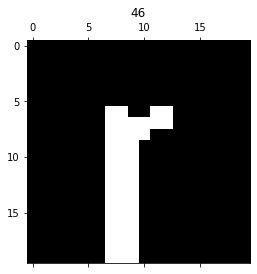

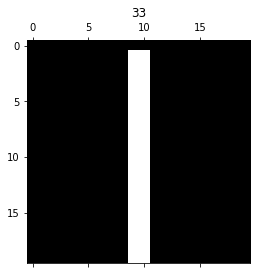

In [86]:
for i in range(images.shape[0]):
    plt.matshow(images[i], cmap='gray')
    plt.title(final_pred[i])

# Save Model

In [36]:
prob_model.save('./models/character-recognition-update')

INFO:tensorflow:Assets written to: ./models/character-recognition-update/assets
